In [5]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks, correlate
from IPython.display import HTML
from tqdm import tqdm
import pickle
import matplotlib.cm as cm
import visualisation as vis
from delta_hes_model import *

In [27]:
#set the lattice of the cells 
P = 2
Q = 1

lattice = get_lattice(P, Q)

# set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 50

T_coupling = 0
w_h = 1
l = 5
n = 3

# the important parameters for this test
T_h = 20     # delay in Hes of first cell

num_tsteps = 60000
dt = 0.1

In [28]:
#uncoupled periods: 
w_coupling = 0 

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False , grad_coup = False, grad_hes_strength = 0, grad_coup_strength = 0)


In [29]:
hes_delays = np.linspace(0, 1, 11) + 20 

results_uncoupled = np.zeros((len(hes_delays), num_tsteps, 2))

for i in range(len(hes_delays)):
    T_h = hes_delays[i]  # set the delay in Hes of first cell
    params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False , grad_coup = False, grad_hes_strength = 0, grad_coup_strength = 0)
    h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
    results_uncoupled[i,:,0] = h[:,0].flatten()
    results_uncoupled[i,:,1] = d[:,0].flatten()


100%|██████████| 59999/59999 [00:16<00:00, 3749.45it/s]


In [30]:
def estimate_period_from_peaks(signal, time=None, height=None, distance=500, prominence=None):
    """
    Estimate the period of an oscillating signal using peak detection.

    Parameters:
    - signal: 1D numpy array of the signal values
    - time: Optional 1D array of time values (same length as signal). If None, assume uniform time steps.
    - height, distance, prominence: Optional arguments passed to find_peaks
    - ignore_initial_outlier: If True, ignores the first peak if it's a large outlier

    Returns:
    - period: Estimated average period (float)
    - peak_times: Time values of the detected peaks
    """
    # Find peaks
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)

    if len(peaks) < 2:
        return None, np.array([])  # Not enough peaks to estimate period

    # Optionally remove initial outlier peak
    peak_vals = signal[peaks]

    # Assume uniform spacing if time is not given
    if time is None:
        time = np.arange(len(signal))

    peak_times = time[peaks]

    if len(peak_times) < 2:
        return None, peak_times  # Still not enough peaks

    # Calculate differences between consecutive peaks
    peak_diffs = np.diff(peak_times)
    period = np.mean(peak_diffs)

    return period, peak_times

Periods for uncoupled oscillations: [125.11276596 125.58723404 126.05957447 126.56304348 127.03478261
 127.50869565 127.9826087  128.45434783 128.92608696 129.42444444
 129.89555556]


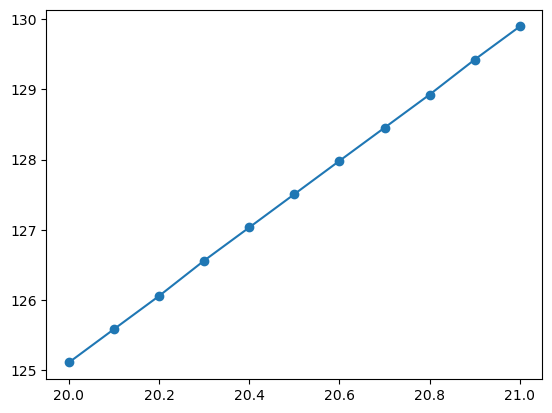

In [31]:
periods_uncoupled = np.zeros(len(hes_delays))

for i in range(len(hes_delays)):
    # Estimate period for each delay
    periods_uncoupled[i], _ = estimate_period_from_peaks(results_uncoupled[i, :, 0], time=np.arange(num_tsteps) * dt, distance=500)

print("Periods for uncoupled oscillations:", periods_uncoupled)

plt.plot(hes_delays, periods_uncoupled, marker='o')

In [24]:
print(type(periods_uncoupled))

<class 'numpy.ndarray'>


In [25]:
with open('periods_uncoupled.pickle', 'wb') as f:
    pickle.dump(periods_uncoupled, f)

In [26]:
with open('periods_uncoupled.pickle', 'rb') as f:
    loaded_periods_uncoupled = pickle.load(f)